Epoch 1/20 | Train Loss: 3.7913 | Val Loss: 3.1229
Epoch 2/20 | Train Loss: 1.4305 | Val Loss: 0.1968
Epoch 3/20 | Train Loss: 0.1127 | Val Loss: 0.0313
Epoch 4/20 | Train Loss: 0.0333 | Val Loss: 0.0160
Epoch 5/20 | Train Loss: 0.0202 | Val Loss: 0.0110
Epoch 6/20 | Train Loss: 0.0151 | Val Loss: 0.0083
Epoch 7/20 | Train Loss: 0.0116 | Val Loss: 0.0065
Epoch 8/20 | Train Loss: 0.0095 | Val Loss: 0.0053
Epoch 9/20 | Train Loss: 0.0078 | Val Loss: 0.0044
Epoch 10/20 | Train Loss: 0.0066 | Val Loss: 0.0037
Epoch 11/20 | Train Loss: 0.0057 | Val Loss: 0.0032
Epoch 12/20 | Train Loss: 0.0050 | Val Loss: 0.0028
Epoch 13/20 | Train Loss: 0.0044 | Val Loss: 0.0025
Epoch 14/20 | Train Loss: 0.0038 | Val Loss: 0.0022
Epoch 15/20 | Train Loss: 0.0035 | Val Loss: 0.0020
Epoch 16/20 | Train Loss: 0.0031 | Val Loss: 0.0018
Epoch 17/20 | Train Loss: 0.0028 | Val Loss: 0.0016
Epoch 18/20 | Train Loss: 0.0026 | Val Loss: 0.0015
Epoch 19/20 | Train Loss: 0.0023 | Val Loss: 0.0013
Epoch 20/20 | Train L

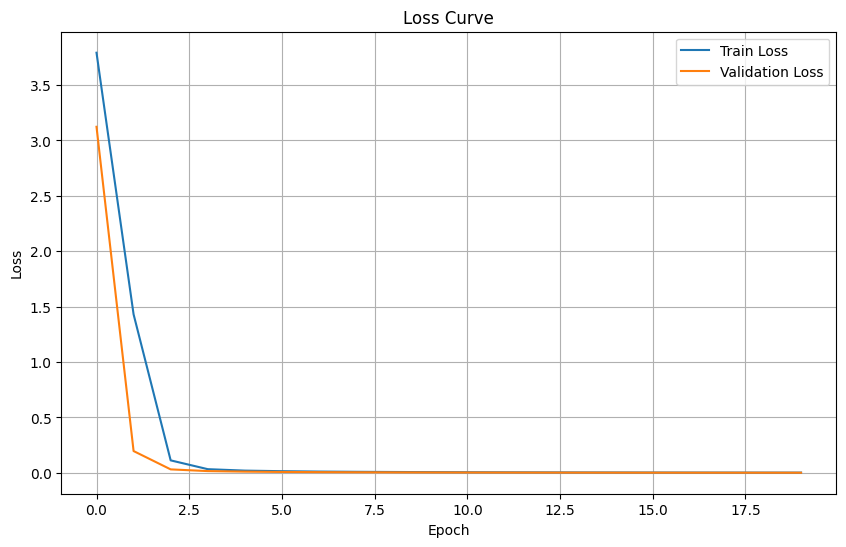

Model saved to ocean_transformer.pth
Final Validation Accuracy: 100.00%


In [5]:
### 1. Import Libraries
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import random
import matplotlib.pyplot as plt

### 2. Seed for Reproducibility
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### 3. Sample Toy Dataset
# We'll use a dummy sequence dataset (seq2seq style task)
VOCAB_SIZE = 50
MAX_LEN = 10

def generate_data(num_samples=1000):
    X = torch.randint(2, VOCAB_SIZE, (num_samples, MAX_LEN))
    y = torch.roll(X, shifts=1, dims=1)  # Just shift sequence right (predict next token)
    return X, y

X_train, y_train = generate_data(800)
X_val, y_val = generate_data(200)


### 4. Core Transformer Block
class TransformerBlock(nn.Module):
    def __init__(self, embed_dim, heads, ff_hidden_dim, dropout=0.1):
        super().__init__()
        self.attention = nn.MultiheadAttention(embed_dim, heads, dropout=dropout, batch_first=True)
        self.norm1 = nn.LayerNorm(embed_dim)
        self.ff = nn.Sequential(
            nn.Linear(embed_dim, ff_hidden_dim),
            nn.ReLU(),
            nn.Linear(ff_hidden_dim, embed_dim)
        )
        self.norm2 = nn.LayerNorm(embed_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        attn_out, _ = self.attention(x, x, x)
        x = self.norm1(x + self.dropout(attn_out))
        ff_out = self.ff(x)
        x = self.norm2(x + self.dropout(ff_out))
        return x


### 5. Full Model
class OceanTransformer(nn.Module):
    def __init__(self, vocab_size, embed_dim=128, num_layers=4, heads=4, ff_hidden_dim=512, dropout=0.1, max_len=MAX_LEN):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.pos_embedding = nn.Parameter(torch.randn(1, max_len, embed_dim))
        self.layers = nn.ModuleList([
            TransformerBlock(embed_dim, heads, ff_hidden_dim, dropout) for _ in range(num_layers)
        ])
        self.fc_out = nn.Linear(embed_dim, vocab_size)

    def forward(self, x):
        pos_emb = self.pos_embedding[:, :x.size(1), :]
        if pos_emb.size(1) < x.size(1):
            # Dynamically expand positional embeddings if needed
            extra_len = x.size(1) - pos_emb.size(1)
            extra_pos_emb = torch.randn(1, extra_len, pos_emb.size(2), device=pos_emb.device)
            pos_emb = torch.cat([pos_emb, extra_pos_emb], dim=1)
        x = self.embedding(x) + pos_emb[:, :x.size(1), :]

        for layer in self.layers:
            x = layer(x)
        out = self.fc_out(x)
        return out

model = OceanTransformer(VOCAB_SIZE).to(device)


### 6. Training Function
def train(model, X_train, y_train, X_val, y_val, epochs=20, batch_size=32, lr=1e-3):
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()

    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        model.train()
        permutation = torch.randperm(X_train.size(0))
        epoch_loss = 0
        for i in range(0, X_train.size(0), batch_size):
            indices = permutation[i:i+batch_size]
            batch_x, batch_y = X_train[indices].to(device), y_train[indices].to(device)

            optimizer.zero_grad()
            outputs = model(batch_x)
            outputs = outputs.view(-1, VOCAB_SIZE)
            batch_y = batch_y.view(-1)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

        train_losses.append(epoch_loss / (X_train.size(0) / batch_size))

        model.eval()
        with torch.no_grad():
            outputs = model(X_val.to(device))
            outputs = outputs.view(-1, VOCAB_SIZE)
            val_y_flat = y_val.view(-1).to(device)
            val_loss = criterion(outputs, val_y_flat).item()
            val_losses.append(val_loss)

        print(f"Epoch {epoch+1}/{epochs} | Train Loss: {train_losses[-1]:.4f} | Val Loss: {val_losses[-1]:.4f}")

    return train_losses, val_losses


### 7. Train the Model
train_losses, val_losses = train(model, X_train, y_train, X_val, y_val)


### 8. Visualization
def plot_losses(train_losses, val_losses):
    plt.figure(figsize=(10,6))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title('Loss Curve')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

plot_losses(train_losses, val_losses)


### 9. Save the Model
MODEL_PATH = "ocean_transformer.pth"
torch.save(model.state_dict(), MODEL_PATH)
print(f"Model saved to {MODEL_PATH}")


### 10. Load (if needed)
# loaded_model = OceanTransformer(VOCAB_SIZE)
# loaded_model.load_state_dict(torch.load(MODEL_PATH))
# loaded_model = loaded_model.to(device)


### 11. Final Evaluation
def evaluate(model, X, y):
    model.eval()
    with torch.no_grad():
        outputs = model(X.to(device))
        preds = torch.argmax(outputs, dim=-1)
        accuracy = (preds == y.to(device)).float().mean()
    return accuracy.item()

final_accuracy = evaluate(model, X_val, y_val)
print(f"Final Validation Accuracy: {final_accuracy*100:.2f}%")


In [6]:
### --- Prediction and Generation Functions --- ###

def predict(model, input_seq):
    """
    Predict next tokens for a batch of sequences.
    """
    model.eval()
    input_seq = input_seq.to(device)
    with torch.no_grad():
        output_logits = model(input_seq)
        predicted_tokens = torch.argmax(output_logits, dim=-1)
    return predicted_tokens

def generate_text(model, start_seq, max_new_tokens=20):
    """
    Generate new tokens by autoregressively predicting one token at a time.
    """
    model.eval()
    generated = start_seq.to(device)

    for _ in range(max_new_tokens):
        with torch.inference_mode():
            output_logits = model(generated)
            next_token_logits = output_logits[:, -1, :]  # only last token
            next_token = torch.argmax(next_token_logits, dim=-1).unsqueeze(1)  # add dimension for batch
            generated = torch.cat((generated, next_token), dim=1)

    return generated

### --- Demo Example --- ###

# Generate some dummy samples
new_X, _ = generate_data(num_samples=3)
print("Input Sequences:")
print(new_X)

# 1. Predict next tokens
predictions = predict(model, new_X)
print("nPredicted Sequences:")
for idx in range(new_X.size(0)):
    print(f"Sample {idx+1}:")
    print(f"Input   : {new_X[idx].tolist()}")
    print(f"Predicted: {predictions[idx].tolist()}")

# 2. Autoregressive Text Generation (like GPT)
print("nGenerated Sequences (starting from initial input):")
for idx in range(new_X.size(0)):
    generated = generate_text(model, new_X[idx].unsqueeze(0), max_new_tokens=10)
    print(f"nSample {idx+1}:")
    print(f"Start   : {new_X[idx].tolist()}")
    print(f"Generated: {generated.squeeze(0).tolist()}")


Input Sequences:
tensor([[32, 32, 48,  6, 32, 47, 27, 42, 38, 18],
        [ 4, 33, 45, 48, 33, 25, 25, 29, 22,  9],
        [ 7, 43, 45,  6,  3, 29, 43,  3, 10,  2]])
nPredicted Sequences:
Sample 1:
Input   : [32, 32, 48, 6, 32, 47, 27, 42, 38, 18]
Predicted: [18, 32, 32, 48, 6, 32, 47, 27, 42, 38]
Sample 2:
Input   : [4, 33, 45, 48, 33, 25, 25, 29, 22, 9]
Predicted: [9, 4, 33, 45, 48, 33, 25, 25, 29, 22]
Sample 3:
Input   : [7, 43, 45, 6, 3, 29, 43, 3, 10, 2]
Predicted: [2, 7, 43, 45, 6, 3, 29, 43, 3, 10]
nGenerated Sequences (starting from initial input):
nSample 1:
Start   : [32, 32, 48, 6, 32, 47, 27, 42, 38, 18]
Generated: [32, 32, 48, 6, 32, 47, 27, 42, 38, 18, 38, 32, 27, 32, 27, 27, 32, 27, 32, 27]
nSample 2:
Start   : [4, 33, 45, 48, 33, 25, 25, 29, 22, 9]
Generated: [4, 33, 45, 48, 33, 25, 25, 29, 22, 9, 22, 22, 25, 25, 25, 25, 45, 45, 33, 25]
nSample 3:
Start   : [7, 43, 45, 6, 3, 29, 43, 3, 10, 2]
Generated: [7, 43, 45, 6, 3, 29, 43, 3, 10, 2, 10, 7, 10, 10, 7, 43, 10, 7, 

In [7]:
words = [
    'i', 'am', 'learning', 'deep', 'learning', 'with', 'transformers',
    'and', 'it', 'is', 'awesome', 'cool', 'fun', 'powerful', 'today',
    'data', 'science', 'ai', 'models', 'future'
]

# 20 words
word2idx = {word: idx for idx, word in enumerate(words)}
idx2word = {idx: word for word, idx in word2idx.items()}

VOCAB_SIZE = len(words)
MAX_LEN = 8


In [8]:
def generate_word_data(num_samples=500):
    X = []
    y = []
    for _ in range(num_samples):
        start = np.random.choice(words, size=MAX_LEN, replace=True)
        X.append([word2idx[word] for word in start])
        shifted = np.roll(X[-1], -1)  # predict next word (shift left)
        y.append(shifted.tolist())
    return torch.tensor(X), torch.tensor(y)

X_train, y_train = generate_word_data(400)
X_val, y_val = generate_word_data(100)


In [12]:
def predict(model, input_seq):
    model.eval()
    input_seq = input_seq.to(device)
    with torch.no_grad():
        output_logits = model(input_seq)
        predicted_tokens = torch.argmax(output_logits, dim=-1)
    return predicted_tokens

def decode_sequence(seq):
    decoded = []
    for token in seq:
        token_id = token.item()
        word = idx2word.get(token_id, '[UNK]')  # Safely handle unknown tokens
        decoded.append(word)
    return decoded

def generate_text(model, start_seq, max_new_tokens=10):
    model.eval()
    generated = start_seq.to(device)
    for _ in range(max_new_tokens):
        with torch.no_grad():
            output_logits = model(generated)
            next_token_logits = output_logits[:, -1, :]
            next_token = torch.argmax(next_token_logits, dim=-1).unsqueeze(1)
            generated = torch.cat((generated, next_token), dim=1)
    return generated


In [13]:
# Generate new examples
new_X, _ = generate_word_data(3)

print("Input Sequences:")
for idx in range(new_X.size(0)):
    print(f"Input {idx+1}: {decode_sequence(new_X[idx])}")

# Predict next tokens
predictions = predict(model, new_X)

print("nPredicted Sequences:")
for idx in range(new_X.size(0)):
    print(f"Predicted {idx+1}: {decode_sequence(predictions[idx])}")

# Autoregressive Text Generation
print("nGenerated Sequences:")
for idx in range(new_X.size(0)):
    generated = generate_text(model, new_X[idx].unsqueeze(0), max_new_tokens=5)
    print(f"Generated {idx+1}: {decode_sequence(generated.squeeze(0))}")


Input Sequences:
Input 1: ['science', 'learning', 'transformers', 'science', 'transformers', 'i', 'science', 'science']
Input 2: ['awesome', 'learning', 'today', 'awesome', 'data', 'it', 'i', 'data']
Input 3: ['it', 'models', 'cool', 'models', 'it', 'transformers', 'powerful', 'models']
nPredicted Sequences:
Predicted 1: ['transformers', 'science', 'learning', 'transformers', 'science', 'transformers', '[UNK]', 'science']
Predicted 2: ['awesome', 'awesome', 'learning', 'today', 'awesome', 'data', 'it', '[UNK]']
Predicted 3: ['models', 'it', 'models', 'cool', 'models', 'it', 'transformers', 'powerful']
nGenerated Sequences:
Generated 1: ['science', 'learning', 'transformers', 'science', 'transformers', 'i', 'science', 'science', 'science', 'science', 'science', 'science', 'transformers']
Generated 2: ['awesome', 'learning', 'today', 'awesome', 'data', 'it', 'i', 'data', '[UNK]', 'data', '[UNK]', '[UNK]', 'awesome']
Generated 3: ['it', 'models', 'cool', 'models', 'it', 'transformers', 'p

In [18]:
### --- User Input Testing Functions --- ###

def encode_input(user_words):
    """
    Encode a list of words into indices.
    """
    encoded = []
    for word in user_words:
        token_id = word2idx.get(word, None)
        if token_id is not None:
            encoded.append(token_id)
        else:
            print(f"[Warning] Word '{word}' not in vocabulary, skipped.")
    return torch.tensor(encoded).unsqueeze(0)  # shape: [1, sequence_length]

def decode_sequence(seq):
    """
    Decode indices into words safely.
    """
    decoded = []
    for token in seq:
        token_id = token.item()
        word = idx2word.get(token_id, '[UNK]')
        decoded.append(word)
    return decoded

def predict(model, input_seq):
    """
    Predict next tokens.
    """
    model.eval()
    input_seq = input_seq.to(device)
    with torch.no_grad():
        output_logits = model(input_seq)
        predicted_tokens = torch.argmax(output_logits, dim=-1)
    return predicted_tokens

def generate_text(model, start_seq, max_new_tokens=10):
    """
    Generate next tokens autoregressively.
    """
    model.eval()
    generated = start_seq.to(device)
    for _ in range(max_new_tokens):
        with torch.no_grad():
            output_logits = model(generated)
            next_token_logits = output_logits[:, -1, :]
            next_token = torch.argmax(next_token_logits, dim=-1).unsqueeze(1)
            generated = torch.cat((generated, next_token), dim=1)
    return generated


### --- Main User Input Testing --- ###

# 1. Ask user for input
user_input = input("Enter a sequence of words separated by space (e.g., 'i am learning deep'):n")
user_words = user_input.lower().split()

# 2. Encode input
encoded_input = encode_input(user_words)

if encoded_input.size(1) == 0:
    print("[Error] No valid words entered. Please try again.")
else:
    # 3. Predict
    predictions = predict(model, encoded_input)

    # 4. Generate
    generated = generate_text(model, encoded_input, max_new_tokens=5)

    # 5. Show Results
    print("nInput Words:")
    print(user_words)

    print("nPredicted Next Words:")
    print(decode_sequence(predictions.squeeze(0)))

    print("nGenerated Full Sequence:")
    print(decode_sequence(generated.squeeze(0)))


Enter a sequence of words separated by space (e.g., 'i am learning deep'):nai
nInput Words:
['ai']
nPredicted Next Words:
['ai']
nGenerated Full Sequence:
['ai', 'ai', 'ai', 'ai', 'ai', 'ai']
